## Loading packages and savepaths

In [ ]:
import os
import h5py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import getpass
import glob
import seaborn as sns
import functions
import lfp_pre_processing_functions
import power_functions
import coherence_functions
import spectrogram_plotting_functions
import plotting_styles
import scipy.stats
import mne_connectivity
importlib.reload(functions) #loads our custom made functions.py file
importlib.reload(spectrogram_plotting_functions)
importlib.reload(plotting_styles)

linestyle = plotting_styles.linestyles
colors = plotting_styles.colors

In [ ]:
%pip install mne-qt-browser
%matplotlib qt
import mne
print(mne.get_config())  # same as mne.get_config(key=None)
mne.set_config('MNE_BROWSER_BACKEND', 'qt')  # set the backend to matplotlib

In [ ]:
#Fetch the current user
user= (getpass.getuser())
print("Hello", user)

if user == 'CPLab':
    base='D:\\Dropbox\\CPLab'
else:
    base='C:\\Users\\{}\\Dropbox\\CPLab'.format(user)
#Set the basepath, savepath and load the data files
files = glob.glob(base+'\\all_data_mat_250825\\*.mat')
savepath = base+'\\results\\'
print("Base path:", base)
print("Save path:", savepath)
print(files)


all_bands_dict = {'total':[1,100], 'beta':[12,30], 'gamma':[30,80], 'theta':[4,12]}


In [ ]:
time_window = 1
fs = 2000

## Making MNE Epochs Arrays

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
import mne_connectivity
import sys
importlib.reload(lfp_pre_processing_functions)
#files=[f'C:\\Users\\{user}\\Dropbox\\CPLab\\all_data_mat\\20230616_dk6_BW_context_day2.mat']
event_data_df=[]
con_data_df=[]

con_data_df_shuffled=[]
shuffled_event_data_df=[]
events_codes_all = {}
random_baseline_data=[]
baseline_lfp_all=[]

files_short=[files[10]] ### TEST CHANGE THIS 


for file_num,file in enumerate(files):
    #if 'dk1' in file:
        
        #print(file)
        base_name = os.path.basename(file)
        base_name, _ = os.path.splitext(base_name)

        date, rat_id, task = lfp_pre_processing_functions.exp_params(base_name)
        print(date, rat_id, task)
        if task == 'nocontextday2' or task == 'nocontextos2':
            task = 'nocontext'
        if task =='nocontext':
            continue
        # if rat_id=='dk1': #REMOVING DK1 TEMPORARLILY . PLEASE CHANGE LATER
        #     continue
        f = h5py.File(file, 'r')
        channels = list(f.keys())
        #print(channels)
         
        if not any("AON" in channel or "vHp" in channel for channel in channels):
            print("No AON or vHp channels in this file")
            continue

        events,reference_electrode=lfp_pre_processing_functions.get_keyboard_and_ref_channels(f,channels)

    #finding global start and end time of all channels, since they start and end recordings at different times
        global_start_time, global_end_time=lfp_pre_processing_functions.find_global_start_end_times(f,channels)
        
        ## Reference electrode finding and padding
        reference_time = np.array(reference_electrode['times']).flatten()
        reference_value = np.array(reference_electrode['values']).flatten()
        padd_ref_data,padded_ref_time=lfp_pre_processing_functions.pad_raw_data_raw_time(reference_value,reference_time,global_start_time,global_end_time,sampling_rate=2000)

        events_codes = np.array(events['codes'][0])
        events_times = np.array(events['times'][0])
        events_codes_all[base_name] = events_codes
        epochs = lfp_pre_processing_functions.generate_epochs_with_first_event(events_codes, events_times)
        #epochs = functions.generate_specific_num_of_epochs_with_first_event(events_codes, events_times,5)
        aon_lfp_channels=[x for x in channels if 'AON' in x ]
        vHp_lfp_channels=[x for x in channels if 'vHp' in x ]
        ref_lfp_channels=[x for x in channels if "Ref" in x or 'REF' in x or 'ref' in x]
        all_channels=np.concatenate((aon_lfp_channels,vHp_lfp_channels, ref_lfp_channels))
        #print(all_channels)
        
        mne_baseline_data=np.zeros((1,len(all_channels),4000))
        mne_epoch_door_before=np.zeros((len(epochs),len(all_channels),int(time_window*fs)))
        mne_epoch_door_after=np.zeros((len(epochs),len(all_channels),int(time_window*fs)))
        mne_epoch_dig_before=np.zeros((len(epochs),len(all_channels),int(time_window*fs)))
        mne_epoch_dig_after=np.zeros((len(epochs),len(all_channels),int(time_window*fs)))
        mne_epoch_around_door=np.zeros((len(epochs),len(all_channels),int(time_window*fs)*2))
        mne_epoch_around_dig=np.zeros((len(epochs),len(all_channels),int(time_window*fs)*2))
        
        mne_baseline_data_shuffled=np.zeros((1,len(all_channels),4000))
        mne_epoch_door_before_shuffled=np.zeros((len(epochs),len(all_channels),int(time_window*fs)))
        mne_epoch_door_after_shuffled=np.zeros((len(epochs),len(all_channels),int(time_window*fs)))
        mne_epoch_dig_before_shuffled=np.zeros((len(epochs),len(all_channels),int(time_window*fs)))
        mne_epoch_dig_after_shuffled=np.zeros((len(epochs),len(all_channels),int(time_window*fs)))
        mne_epoch_around_door_shuffled=np.zeros((len(epochs),len(all_channels),int(time_window*fs*2)))
        mne_epoch_around_dig_shuffled=np.zeros((len(epochs),len(all_channels),int(time_window*fs*2)))

        print(f'File {rat_id} {task} {date} has {len(epochs)} epochs and {len(all_channels)} channels')


        first_event = events_times[0]
        
        for channel_num,channeli in enumerate(all_channels):
            if "AON" in channeli or "vHp" in channeli or "Ref" in channeli:
                channel_id = channeli
                data_all = f[channeli]
                raw_data = np.array(data_all['values']).flatten()
                raw_time = np.array(data_all['times']).flatten()
                sampling_rate = int(1 / data_all['interval'][0][0])
                #print(raw_data.shape, raw_time.shape, sampling_rate)
                
                padded_data,padded_time=lfp_pre_processing_functions.pad_raw_data_raw_time(raw_data,raw_time,global_start_time,global_end_time,sampling_rate)

                # padded_data = padded_data/8000 #Accounting for the 8000Amplifier
                # padd_ref_data = padd_ref_data/8000
                if "Ref" in channeli:
                    subtracted_data = padded_data
                else:                
                    subtracted_data = padded_data - padd_ref_data # Subtracting reference channel

                notch_data = lfp_pre_processing_functions.iir_notch(subtracted_data, sampling_rate, 60) ###CHANGE notch_data to notch_filtered_data

                #print(notch_data.nbytes)
                #notch_data_detrended = scipy.signal.detrend(notch_data)
                #notch_filtered_data=lfp_pre_processing_functions.sosbandpass(notch_data_detrended, fs=2000, start_freq=1,end_freq=100, order=8) ###CHANGE THIS FOR NOT BANDBASS FILTERTING
                #print(notch_filtered_data.nbytes)
                
                data_before, time, baseline_mean, baseline_std=lfp_pre_processing_functions.baseline_data_normalization(notch_data, raw_time, first_event, sampling_rate)
                first_event_index=np.where(raw_time>first_event)[0][0]

                mne_baseline_data[0,channel_num,:]=list(data_before)
                mne_baseline_data_shuffled[0,channel_num,:]=list(np.random.permutation(data_before))
                total = notch_data

                epoch_metadata =[]

                for i, epochi in enumerate(epochs):
                    door_timestamp = epochi[0][0]
                    trial_type = epochi[0][1]
                    dig_type = epochi[1, 1]
                    #print(dig_type)
                    dig_timestamp = epochi[1, 0]
                    #print(door_timestamp, trial_type, dig_timestamp, dig_type)

                                        # Calculate the time difference
                    time_diff = dig_timestamp - door_timestamp
                    
                    # Store metadata for this epoch
                    epoch_metadata.append({
                        'epoch_id': i,
                        'door_timestamp': door_timestamp,
                        'dig_timestamp': dig_timestamp,
                        'time_diff': time_diff,
                        'trial_type': trial_type,
                        'dig_type': dig_type
                    })


                    data_trial_before, data_trial_after=lfp_pre_processing_functions.extract_event_data(notch_data,time,door_timestamp,sampling_rate,truncation_time=time_window)
                    data_dig_before, data_dig_after=lfp_pre_processing_functions.extract_event_data(notch_data,time,dig_timestamp,sampling_rate,truncation_time=time_window)
                    data_around_door=np.concatenate((data_trial_before, data_trial_after))
                    data_around_dig=np.concatenate((data_dig_before, data_dig_after))

                    epoch_data = [data_trial_before, data_trial_after, data_dig_before, data_dig_after, data_around_door, data_around_dig]
                    event_data_list = [lfp_pre_processing_functions.zscore_event_data(x, baseline_std) for x in epoch_data]

                    #event_data_list = [x for x in epoch_data]

                    mne_epoch_door_before[i,channel_num,:]=list(event_data_list[0][-int(time_window*fs):])
                    mne_epoch_door_after[i,channel_num,:]=list(event_data_list[1][:int(time_window*fs)])
                    mne_epoch_dig_before[i,channel_num,:]=list(event_data_list[2][-int(time_window*fs):])
                    mne_epoch_dig_after[i,channel_num,:]=list(event_data_list[3][:int(time_window*fs)])
                    mid_point = int(len(event_data_list[4]) / 2)
                    mne_epoch_around_door[i,channel_num,:]=list(event_data_list[4][mid_point-int(time_window*fs):mid_point+int(time_window*fs)])
                    mne_epoch_around_dig[i,channel_num,:]=list(event_data_list[5][mid_point-int(time_window*fs):mid_point+int(time_window*fs)])

                    mne_epoch_door_before_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[0][-int(time_window*fs):]))
                    mne_epoch_door_after_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[1][:int(time_window*fs)]))
                    mne_epoch_dig_before_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[2][-int(time_window*fs):]))
                    mne_epoch_dig_after_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[3][:int(time_window*fs)]))
                    mne_epoch_around_door_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[4][mid_point-int(time_window*fs):mid_point+int(time_window*fs)]))
                    mne_epoch_around_dig_shuffled[i,channel_num,:]=list(np.random.permutation(event_data_list[5][mid_point-int(time_window*fs):mid_point+int(time_window*fs)]))

        if len(all_channels)>0:
            fs=2000
            freqs = np.arange(1,100)
            n_cycles = freqs/3
            
            info = mne.create_info(ch_names=list(all_channels), sfreq=fs, ch_types='eeg')
            
            metadata_df = pd.DataFrame(epoch_metadata)

            mne_baseline = mne.EpochsArray(mne_baseline_data, info)
            mne_epoch_door_before = mne.EpochsArray(mne_epoch_door_before, info,metadata=metadata_df)
            mne_epoch_door_after= mne.EpochsArray(mne_epoch_door_after, info,metadata=metadata_df)
            mne_epoch_dig_before = mne.EpochsArray(mne_epoch_dig_before, info,metadata=metadata_df)
            mne_epoch_dig_after = mne.EpochsArray(mne_epoch_dig_after, info,metadata=metadata_df)
            mne_epoch_around_door = mne.EpochsArray(mne_epoch_around_door, info,metadata=metadata_df)
            mne_epoch_around_dig = mne.EpochsArray(mne_epoch_around_dig, info,metadata=metadata_df)
            
            events_list = [mne_epoch_door_before,mne_epoch_door_after,mne_epoch_dig_before,mne_epoch_dig_after,mne_epoch_around_door,mne_epoch_around_dig]
            
            row_list=[file_num,date,rat_id,task,mne_baseline,mne_epoch_door_before,mne_epoch_door_after,mne_epoch_dig_before,mne_epoch_dig_after,mne_epoch_around_door,mne_epoch_around_dig]
            
            mne_baseline_shuffled = mne.EpochsArray(mne_baseline_data_shuffled, info)
            mne_epoch_door_before_shuffled = mne.EpochsArray(mne_epoch_door_before_shuffled, info)
            mne_epoch_door_after_shuffled = mne.EpochsArray(mne_epoch_door_after_shuffled, info)
            mne_epoch_dig_before_shuffled = mne.EpochsArray(mne_epoch_dig_before_shuffled, info)
            mne_epoch_dig_after_shuffled = mne.EpochsArray(mne_epoch_dig_after_shuffled, info)
            mne_epoch_around_door_shuffled = mne.EpochsArray(mne_epoch_around_door_shuffled, info)
            mne_epoch_around_dig_shuffled = mne.EpochsArray(mne_epoch_around_dig_shuffled, info)
            row_list_shuffled=[file_num,date,rat_id,task,mne_baseline_shuffled,mne_epoch_door_before_shuffled,mne_epoch_door_after_shuffled,mne_epoch_dig_before_shuffled,mne_epoch_dig_after_shuffled,mne_epoch_around_door_shuffled,mne_epoch_around_dig_shuffled]
            shuffled_event_data_df.append(row_list_shuffled)

            con_data_df.append(row_list)
            con_data_df_shuffled.append(row_list_shuffled)


con_data_df=pd.DataFrame(con_data_df, columns=['experiment','date','rat_id','task','mne_baseline','mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after','mne_epoch_around_door','mne_epoch_around_dig'])
con_data_df.to_pickle(savepath+f'raw_mne_epochs_array_df_truncated_{int(time_window*fs)}.pkl')

con_data_df_shuffled=pd.DataFrame(con_data_df_shuffled, columns=['experiment','date','rat_id','task','mne_baseline','mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after','mne_epoch_around_door','mne_epoch_around_dig'])
con_data_df_shuffled.to_pickle(savepath+f'raw_mne_epochs_array_df_shuffled_truncated_{int(time_window*fs)}.pkl')


## Bad Epoch Annotation

In [ ]:
con_data_df = pd.read_pickle(savepath+f'raw_mne_epochs_array_df_truncated_{int(time_window*fs)}.pkl')

In [ ]:
test_epoch = con_data_df.iloc[0]['mne_epoch_dig_before']
aon_indices = [i for i, ch in enumerate(test_epoch.ch_names) if 'AON' in ch]
vHp_indices = [i for i, ch in enumerate(test_epoch.ch_names) if 'vHp' in ch]
test_epoch.plot(scalings='auto')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_epochs_with_metadata(epochs, metadata_cols=['time_diff']):
    """
    Interactive epoch viewer that displays metadata for each epoch.
    
    Parameters:
    -----------
    epochs : mne.EpochsArray
        The epochs object to visualize
    metadata_cols : list
        List of metadata column names to display
    
    Usage:
    ------
    bad_epochs = plot_epochs_with_metadata(mne_epoch_door_before, ['time_diff', 'trial_type'])
    # Click through epochs, press 'b' to mark as bad, arrow keys to navigate
    # Close window when done
    """
    
    n_epochs = len(epochs)
    current_idx = [0]  # Use list to allow modification in nested function
    bad_epochs = set()
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 10), 
                            gridspec_kw={'height_ratios': [4, 1]})
    
    def update_plot():
        idx = current_idx[0]
        
        # Clear previous plots
        axes[0].clear()
        axes[1].clear()
        
        # Plot epoch data
        epoch_data = epochs[idx].get_data()[0]  # shape: (n_channels, n_times)
        times = epochs.times
        
        for ch_idx, ch_data in enumerate(epoch_data):
            axes[0].plot(times, ch_data + ch_idx * 5, label=epochs.ch_names[ch_idx])
        
        axes[0].set_xlabel('Time (s)')
        axes[0].set_ylabel('Channels (offset)')
        axes[0].legend(loc='upper right', fontsize=8)
        axes[0].grid(True, alpha=0.3)
        
        # Create title with metadata
        title = f"Epoch {idx}/{n_epochs-1}"
        if epochs.metadata is not None:
            for col in metadata_cols:
                if col in epochs.metadata.columns:
                    val = epochs.metadata.iloc[idx][col]
                    title += f" | {col}: {val:.4f}" if isinstance(val, (int, float)) else f" | {col}: {val}"
        
        # Add bad epoch indicator
        if idx in bad_epochs:
            title += " | *** MARKED BAD ***"
            axes[0].set_facecolor('#ffcccc')
        else:
            axes[0].set_facecolor('white')
            
        axes[0].set_title(title, fontsize=12, fontweight='bold')
        
        # Show metadata table in bottom subplot
        axes[1].axis('off')
        if epochs.metadata is not None:
            metadata_text = "Metadata:\n"
            for col in epochs.metadata.columns:
                val = epochs.metadata.iloc[idx][col]
                metadata_text += f"{col}: {val}\n"
            axes[1].text(0.1, 0.5, metadata_text, fontsize=10, verticalalignment='center',
                        family='monospace')
        
        # Add instructions
        instructions = "Navigation: ← → arrows | Mark bad: 'b' | Quit: 'q' or close window"
        axes[1].text(0.1, 0.05, instructions, fontsize=9, style='italic')
        
        fig.canvas.draw()
    
    def on_key(event):
        if event.key == 'right':
            current_idx[0] = min(current_idx[0] + 1, n_epochs - 1)
            update_plot()
        elif event.key == 'left':
            current_idx[0] = max(current_idx[0] - 1, 0)
            update_plot()
        elif event.key == 'b':
            idx = current_idx[0]
            if idx in bad_epochs:
                bad_epochs.remove(idx)
                print(f"Epoch {idx} unmarked as bad (Total bad: {len(bad_epochs)})")
            else:
                bad_epochs.add(idx)
                print(f"Epoch {idx} marked as bad (Total bad: {len(bad_epochs)})")
            update_plot()
        elif event.key == 'q':
            plt.close(fig)
    
    fig.canvas.mpl_connect('key_press_event', on_key)
    
    # Initial plot
    update_plot()
    plt.tight_layout()
    plt.show(block=True)  # Ensure blocking behavior
    
    # Return list of bad epochs (after window closes)
    bad_list = sorted(list(bad_epochs))
    print(f"\n=== FINAL RESULTS ===")
    print(f"Total bad epochs marked: {len(bad_list)}")
    print(f"Bad epoch indices: {bad_list}")
    
    return bad_list


# Usage example:
# bad_epochs = plot_epochs_with_metadata(mne_epoch_door_before, ['time_diff', 'trial_type', 'dig_type'])
# 
# # Then mark them in your epochs object:
# if len(bad_epochs) > 0:
#     mne_epoch_door_before.drop(bad_epochs, reason='manual_review')


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

def plot_epochs_grid_with_metadata(epochs, metadata_cols=['time_diff'], n_cols=4):
    """
    Interactive epoch grid viewer that displays all epochs and metadata.
    Click on epochs to mark as bad.
    
    Parameters:
    -----------
    epochs : mne.EpochsArray
        The epochs object to visualize
    metadata_cols : list
        List of metadata column names to display
    n_cols : int
        Number of columns in the grid
    
    Usage:
    ------
    bad_epochs = plot_epochs_grid_with_metadata(mne_epoch_door_before, ['time_diff', 'trial_type'], n_cols=5)
    # Click on epochs to toggle bad/good
    # Press 'q' to finish and close
    """
    
    n_epochs = len(epochs)
    n_rows = int(np.ceil(n_epochs / n_cols))
    bad_epochs = set()
    
    # Create figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    fig.suptitle('Click on epochs to mark as BAD (red border). Press "q" when done.', 
                 fontsize=14, fontweight='bold')
    
    # Flatten axes for easier indexing
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    axes = axes.flatten() if n_rows > 1 or n_cols > 1 else [axes]
    
    # Store rectangles for each subplot
    rectangles = {}
    
    def plot_epoch(idx, ax):
        """Plot a single epoch in the given axis"""
        ax.clear()
        
        if idx >= n_epochs:
            ax.axis('off')
            return
        
        # Get epoch data
        epoch_data = epochs[idx].get_data()[0]  # shape: (n_channels, n_times)
        times = epochs.times
        
        # Plot each channel with offset
        for ch_idx, ch_data in enumerate(epoch_data):
            ax.plot(times, ch_data + ch_idx * 5, linewidth=0.8, alpha=0.7)
        
        # Create title with metadata
        title = f"Epoch {idx}"
        if epochs.metadata is not None:
            for col in metadata_cols:
                if col in epochs.metadata.columns:
                    val = epochs.metadata.iloc[idx][col]
                    if isinstance(val, (int, float)):
                        title += f"\n{col}: {val:.3f}"
                    else:
                        title += f"\n{col}: {val}"
        
        ax.set_title(title, fontsize=9, fontweight='bold')
        ax.set_xlabel('Time (s)', fontsize=8)
        ax.tick_params(labelsize=7)
        ax.grid(True, alpha=0.3)
        
        # Add red border if marked as bad
        if idx in bad_epochs:
            for spine in ax.spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(4)
            ax.set_facecolor('#ffcccc')
        else:
            for spine in ax.spines.values():
                spine.set_edgecolor('black')
                spine.set_linewidth(1)
            ax.set_facecolor('white')
    
    def update_all_plots():
        """Redraw all epoch plots"""
        for idx, ax in enumerate(axes):
            plot_epoch(idx, ax)
        fig.canvas.draw_idle()
    
    def on_click(event):
        """Handle mouse click events"""
        if event.inaxes is None:
            return
        
        # Find which subplot was clicked
        for idx, ax in enumerate(axes):
            if ax == event.inaxes and idx < n_epochs:
                # Toggle bad epoch status
                if idx in bad_epochs:
                    bad_epochs.remove(idx)
                    print(f"Epoch {idx} unmarked as bad (Total bad: {len(bad_epochs)})")
                else:
                    bad_epochs.add(idx)
                    print(f"Epoch {idx} marked as bad (Total bad: {len(bad_epochs)})")
                
                # Redraw just this subplot
                plot_epoch(idx, ax)
                fig.canvas.draw_idle()
                break
    
    def on_key(event):
        """Handle keyboard events"""
        if event.key == 'q':
            plt.close(fig)
        elif event.key == 'r':
            # Reset all bad epochs
            bad_epochs.clear()
            print("All bad epoch markings cleared")
            update_all_plots()
    
    # Connect event handlers
    fig.canvas.mpl_connect('button_press_event', on_click)
    fig.canvas.mpl_connect('key_press_event', on_key)
    
    # Initial plot of all epochs
    update_all_plots()
    
    plt.tight_layout()
    plt.show(block=True)
    
    # Return list of bad epochs (after window closes)
    bad_list = sorted(list(bad_epochs))
    print(f"\n=== FINAL RESULTS ===")
    print(f"Total bad epochs marked: {len(bad_list)}")
    print(f"Bad epoch indices: {bad_list}")
    
    return bad_list


# Usage example:
# bad_epochs = plot_epochs_grid_with_metadata(
#     mne_epoch_door_before, 
#     metadata_cols=['time_diff', 'trial_type', 'dig_type'],
#     n_cols=5
# )
# 
# # Then mark them in your epochs object:
# if len(bad_epochs) > 0:
#     mne_epoch_door_before.drop(bad_epochs, reason='manual_review')

In [ ]:
%matplotlib qt
bad_epochs = plot_epochs_grid_with_metadata(test_epoch, ['time_diff', 'trial_type', 'dig_type'])

In [ ]:
print(bad_epochs)

In [ ]:

# Then mark them in your epochs object:
if len(bad_epochs) > 0:
    test_epoch.drop(bad_epochs, reason='manual_review')
print(test_epoch)

In [ ]:
con_data_df_manual.loc['mne_epoch_dig_before_manual'] = bad_epochs

### Dig Before

In [ ]:
con_data_df_manual = con_data_df.copy()

print(con_data_df_manual.shape[0])
# Create the column FIRST with empty lists
all_bad_epochs = []
for row in range(con_data_df_manual.shape[0]):
    epoch1 = con_data_df_manual.iloc[row]['mne_epoch_dig_before']
    bad_epochs = plot_epochs_with_metadata(epoch1, ['time_diff', 'trial_type', 'dig_type'])
    all_bad_epochs.append(bad_epochs)

con_data_df_manual['bad_epochs_dig_before'] = all_bad_epochs

### Dig After

In [ ]:
print(con_data_df_manual.shape[0])
# Create the column FIRST with empty lists
all_bad_epochs = []
for row in range(con_data_df_manual.shape[0]):
    epoch1 = con_data_df_manual.iloc[row]['mne_epoch_dig_after']
    bad_epochs = plot_epochs_with_metadata(epoch1, ['time_diff', 'trial_type', 'dig_type'])
    all_bad_epochs.append(bad_epochs)

con_data_df_manual['bad_epochs_dig_after'] = all_bad_epochs

### Door Before

In [ ]:
print(con_data_df_manual.shape[0])
# Create the column FIRST with empty lists
all_bad_epochs = []
for row in range(con_data_df_manual.shape[0]):
    epoch1 = con_data_df_manual.iloc[row]['mne_epoch_door_before']
    bad_epochs = plot_epochs_with_metadata(epoch1, ['time_diff', 'trial_type', 'dig_type'])
    all_bad_epochs.append(bad_epochs)

con_data_df_manual['bad_epochs_door_before'] = all_bad_epochs

In [ ]:
con_data_df_manual.to_pickle(savepath + f'marked_mne_epochs_array_df_truncated_{int(time_window*fs)}_231125.pkl')

In [ ]:
con_data_df_marked = pd.read_pickle(savepath + f'marked_mne_epochs_array_df_truncated_{int(time_window*fs)}_231125.pkl')

In [ ]:
door_before_dropped_total = 0
dig_before_dropped_total = 0
dig_after_dropped_total = 0

for row in range(con_data_df_marked.shape[0]):
    door_before = con_data_df_marked.iloc[row]['mne_epoch_door_before']
    dig_before = con_data_df_marked.iloc[row]['mne_epoch_dig_before']    
    dig_after = con_data_df_marked.iloc[row]['mne_epoch_dig_after']
    
    door_before_bad_epochs = con_data_df_marked.iloc[row]['bad_epochs_door_before']
    dig_before_bad_epochs = con_data_df_marked.iloc[row]['bad_epochs_dig_before']    
    dig_after_bad_epochs = con_data_df_marked.iloc[row]['bad_epochs_dig_after']
    
    door_before.drop(door_before_bad_epochs)
    dig_before.drop(dig_before_bad_epochs)
    dig_after.drop(dig_after_bad_epochs)
    
    door_before_dropped_total = door_before_dropped_total + len(door_before_bad_epochs)
    dig_before_dropped_total = dig_before_dropped_total + len(dig_before_bad_epochs)
    dig_after_dropped_total = dig_after_dropped_total + len(dig_after_bad_epochs)

print("Total Door Before Epochs Dropped - ", door_before_dropped_total, "Out of", 20*27)
print("Total Dig Before Epochs Dropped - ", dig_before_dropped_total, "Out of", 20*27)
print("Total Dig After Epochs Dropped - ", dig_after_dropped_total, "Out of", 20*27)

## Coherence average

In [ ]:
##############

time_window = 1
fs = 2000  # Sampling frequency
tanh_norm = True
###############
def coherogram_pkl(time_window, fs, tanh_norm, filepath):
    if tanh_norm:
        suffix ='_normalized'
    else:
        suffix ='_non-normalized'


    con_data_df_clean=pd.read_pickle(filepath)

    event_list=['mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after']

    print(event_list)
    BWcontext_data=con_data_df_clean[(con_data_df_clean['task']=='BWcontext')]
    BWnocontext_data=con_data_df_clean[(con_data_df_clean['task']=='BWnocontext')]
    task_data_dict={'BWcontext':BWcontext_data,'BWnocontext':BWnocontext_data}

    all_con_data=[]
    all_con_data_mean=[]
    for task_num,task_name in enumerate(task_data_dict.keys()):
            task_data=task_data_dict[task_name]
            row=[task_name]
            #print(row)
            row_2=[task_name]
            for event in event_list:
                #print(event)
                event_epoch_list=task_data[event]
                aon_vHp_con=[]
                for event_epoch in event_epoch_list:
                        #print(row,event, event_epoch) 
                        print(event_epoch.events.shape[0])
                        if event_epoch.events.shape[0] <5:
                            
                            print(f"Skipping {event} for {task_name} due to insufficient events")
                            continue
                        fmin=1
                        fmax=100
                        fs=2000
                        freqs = np.arange(fmin,fmax)
                        n_cycles = freqs/3
                        
                        con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),
                                                            mode='cwt_morlet', cwt_freqs=freqs,
                                                            cwt_n_cycles=n_cycles, verbose=False, fmin=fmin, fmax=fmax, faverage=False)
                        
                        ########TRYING HIGHPASS FILTERING FOR ARTIFACT REMOVAL################
                        # epoch_highpass = event_epoch.copy().filter(l_freq = 1, h_freq=None, filter_length = "0.7s" )
                        # con = mne_connectivity.spectral_connectivity_epochs(epoch_highpass, method='coh', sfreq=int(fs),
                        #                                     mode='cwt_morlet', cwt_freqs=freqs,
                        #                                     cwt_n_cycles=n_cycles, verbose=False, fmin=fmin, fmax=fmax, faverage=False)
                        
                        
                        
                        coh = con.get_data(output='dense')
                        indices = con.names
                        

                        for i in range(coh.shape[0]):
                            for j in range(coh.shape[1]):
                                if 'AON' in indices[j] and 'vHp' in indices[i]:
                                    coherence= coh[i,j,:,:]
                                    if tanh_norm:
                                        coherence=np.arctanh(coherence)
                                    aon_vHp_con.append(coherence)
                row.append(np.mean(aon_vHp_con, axis=0))
                row_2.append(np.mean(aon_vHp_con))
            all_con_data.append(row)                    
            all_con_data_mean.append(row_2)
    # Convert all_con_data to a DataFrame for easier manipulation
    all_con_data_df = pd.DataFrame(all_con_data, columns=['task'] + event_list)
    all_con_data_df.to_pickle(savepath+'marked_coherence_spectrogram_before_after_door_dig_truncated_{}{}_231125.pkl'.format(int(time_window*fs), suffix))

coherogram_pkl(time_window=time_window, fs=fs, tanh_norm=tanh_norm)

In [ ]:
##############

time_window = 1
fs = 2000  # Sampling frequency
tanh_norm = True

###############

if tanh_norm:
    suffix ='_normalized'
else:
    suffix ='_non-normalized'

all_con_data_df=pd.read_pickle(savepath+'marked_coherence_spectrogram_before_after_door_dig_truncated_{}{}_231125.pkl'.format(int(time_window*fs), suffix))
event_list=['mne_epoch_door_before','mne_epoch_dig_before','mne_epoch_dig_after']

%matplotlib inline

times=np.arange(0, time_window, 1/fs)
fig, axs=plt.subplots(2,3, figsize=(15,10), sharey=True)
vmin = all_con_data_df[event_list].applymap(np.min).min().min()
vmax = all_con_data_df[event_list].applymap(np.max).max().max()
event_names=['Before Door','Before Dig','After Dig']
for i, event in enumerate(event_list):
    axs[0,i].imshow(all_con_data_df[event][0], extent=[times[0], times[-1], 1, 100],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    axs[0,i].set_xlabel('Time (s)')
    axs[0,i].set_ylabel('Frequency (Hz)')
    axs[0,i].set_title(event_names[i])

    axs[1,i].imshow(all_con_data_df[event][1], extent=[times[0], times[-1], 1, 100],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    axs[1,i].set_xlabel('Time (s)')
    axs[1,i].set_ylabel('Frequency (Hz)')
    axs[1,i].set_title(event_names[i])
    axs[0,0].text(-0.3, 0.5, 'Context', transform=axs[0,0].transAxes, fontsize=14, verticalalignment='center', rotation=90)
    axs[1,0].text(-0.3, 0.5, 'No Context', transform=axs[1,0].transAxes, fontsize=14, verticalalignment='center', rotation=90)
    # Add a colorbar
cbar = fig.colorbar(axs[0,0].images[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Coherence (A.U.)', fontsize=12)
fig.savefig(savepath+f'marked_coherence_spectrogram_before_after_door_dig_{int(time_window*fs/2)}ms{suffix}_231125.png', dpi=1200, bbox_inches='tight')
plt.show()

## Coherence Per Experiment

In [ ]:
###############
time_window = 1
fs = 2000  # Sampling frequency
tanh_norm = True
###############
def coherogram_perexperiment_pkl(time_window, fs, tanh_norm):

    if tanh_norm:
        suffix ='normalized'
    else:
        suffix ='nonnormalized'



    con_data_df_clean=con_data_df_marked

    event_list=['mne_epoch_door_before','mne_epoch_dig_before','mne_epoch_dig_after']

    print(event_list)

    test_list = [con_data_df_clean.iloc[0]]
    mean_con_data=pd.DataFrame()
    def epoch_coherogram(epoch, fmin=1, fmax=100, fs=2000):
            print(epoch.events.shape)
        # if epoch.events.shape[0] < 5:
        #     print("Not enough events in the epoch")
        #     return None
        # else:
            freqs = np.arange(fmin, fmax)
            n_cycles = freqs / 3
            con = mne_connectivity.spectral_connectivity_epochs(epoch, method='coh', sfreq=int(fs),
                                                                mode='cwt_morlet', cwt_freqs=freqs,
                                                                cwt_n_cycles=n_cycles, verbose=False, fmin=fmin, fmax=fmax, faverage=False)
            coh = con.get_data(output='dense')
            indices = con.names
            aon_vHp_con = []
            for i in range(coh.shape[0]):
                for j in range(coh.shape[1]):
                    if 'AON' in indices[j] and 'vHp' in indices[i]:
                        coherence= coh[i,j,:,:]
                        if tanh_norm:
                            coherence=np.arctanh(coherence)
                        aon_vHp_con.append(coherence)
            
            mean_con = np.mean(aon_vHp_con, axis=0)
            return mean_con
    mean_con_data['mne_epoch_door_before'] = con_data_df_clean['mne_epoch_door_before'].apply(epoch_coherogram)
    mean_con_data['mne_epoch_dig_before'] = con_data_df_clean['mne_epoch_dig_before'].apply(epoch_coherogram)
    mean_con_data['mne_epoch_dig_after'] = con_data_df_clean['mne_epoch_dig_after'].apply(epoch_coherogram)

    mean_con_data['experiment'] = con_data_df_clean['experiment']
    mean_con_data['date'] = con_data_df_clean['date']
    mean_con_data['task'] = con_data_df_clean['task']
    mean_con_data['rat_id'] = con_data_df_clean['rat_id']
    mean_con_data.dropna(inplace=True)
    mean_con_data.reset_index(drop=True, inplace=True)

    mean_con_data.to_pickle(savepath + f'marked_coherence_around_events_mean_{int(time_window*fs)}_231125.pkl')

coherogram_perexperiment_pkl(time_window=time_window, fs=fs, tanh_norm=tanh_norm)


In [ ]:
#################
time_window = 1
fs = 2000  # Sampling frequency
tanh_norm = True
#################

event_of_interest = 'mne_epoch_door_before'

def plot_coherogram_perexperiment(time_window, fs, tanh_norm):
    if tanh_norm:
        suffix ='normalized'
    else:
        suffix ='nonnormalized'

    mean_con_data=pd.read_pickle(savepath + f'marked_coherence_around_events_mean_{int(time_window*fs)}_231125.pkl')
    vmin = mean_con_data[event_of_interest].apply(np.min).min()
    vmax = mean_con_data[event_of_interest].apply(np.max).max()

    BWcontext_data=mean_con_data[(mean_con_data['task']=='BWcontext')]
    BWnocontext_data=mean_con_data[(mean_con_data['task']=='BWnocontext')]
    task_data_dict={'BWcontext':BWcontext_data,'BWnocontext':BWnocontext_data}
    rat_ids, rat_nums = np.unique(BWcontext_data['rat_id'], return_counts=True)
    print(rat_ids, rat_nums)
    rat_nums_max = rat_nums.max()
    print(rat_nums_max)
    import matplotlib.pyplot as plt
    writer = pd.ExcelWriter(savepath + 'marked_coherogram_perexperiment_{}_{}_231125.xlsx'.format(int(time_window*fs),suffix))

    for group_name, group_df in task_data_dict.items():
        print(f"Plotting group: {group_name}")
        group_dict = {'BWcontext': 'Context', 'BWnocontext': 'No Context'}
        rat_ids, rat_nums = np.unique(group_df['rat_id'], return_counts=True)
        rat_nums_max = rat_nums.max()

        num_of_rows = 4 # Each row should be a rats
        num_of_cols = rat_nums_max # Each column should be the max number of experiments for a rat

        fig, axs = plt.subplots(num_of_rows, num_of_cols, figsize=(25, 10), sharex=True, sharey=True)
        dk1_count = 0
        dk3_count = 0
        dk5_count = 0
        dk6_count = 0
        for i, (idx, row) in enumerate(group_df.iterrows()):
            rat_id = row['rat_id']
            data = np.array(row[event_of_interest])
            if rat_id == 'dk1':
                ax=axs[0, dk1_count]
                dk1_count += 1
            elif rat_id == 'dk3':
                ax=axs[1, dk3_count]
                dk3_count += 1
            elif rat_id == 'dk5':
                ax=axs[2, dk5_count]
                dk5_count += 1
            elif rat_id == 'dk6':
                ax=axs[3, dk6_count]
                dk6_count += 1
            im = ax.imshow(data, extent=[0, time_window, 1, 100], aspect='auto', origin='lower', cmap='jet', vmin=0, vmax=1)
            ax.set_title(f"{row['rat_id']} {row['date']}")

            ##### Writing to excel

            freqs = [f'{int(freq)}Hz' for freq in np.linspace(1, 100, data.shape[0])]
            freqs.insert(0, 'Frequency (Hz) / Time (s)')
            print(len(freqs))
            time_points = [f'{np.round(t, 3)}s' for t in np.linspace(0, time_window, data.shape[1])]

            df_towrite = pd.DataFrame(data)
            df_towrite.loc[-1] = time_points  # Add time points as the first row
            df_towrite.index = df_towrite.index + 1  # Shift index
            df_towrite = df_towrite.sort_index()
            df_towrite.insert(0, 'Frequency (Hz)/ Time (s)', freqs)
            df_towrite.to_excel(writer, sheet_name=f'{group_dict[group_name]}_{rat_id}_{row["date"]}', index=False)

        for j in range(i + 1, len(axs)):
            fig.delaxes(axs[j])
        fig.suptitle(f"{group_dict[group_name]} Coherence {suffix} {event_of_interest}", fontsize=16)
        fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, label=f'Coherence {suffix}')
        fig.savefig(savepath + f'{group_name}_coherogram_per_experiment_{event_of_interest}_{int(time_window*fs)}_231125.png', dpi=300, bbox_inches='tight')
        #plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()
    writer.close()
plot_coherogram_perexperiment(time_window=time_window, fs=fs, tanh_norm=tanh_norm)

## Calculating Power and Plotting

In [ ]:
suffix ='_normalized'

mne_epochs = pd.read_pickle(savepath + f'marked_mne_epochs_array_df_truncated_{int(time_window*fs)}_181125.pkl')


In [ ]:

def get_power_tfr(epoch):
    fmin=1
    fmax=100
    fs=2000
    freqs = np.arange(fmin,fmax)
    n_cycles = freqs/3

    power = epoch.compute_tfr(
        method="morlet", freqs=freqs, n_cycles=n_cycles, return_itc=False, average=False,
    )

    return power
results = []
for row in mne_epochs.itertuples(index=False):
    experiment, rat_id, task, date = row.experiment, row.rat_id, row.task, row.date
    door_before,door_after = row.mne_epoch_door_before, row.mne_epoch_door_after
    dig_before,dig_after = row.mne_epoch_dig_before, row.mne_epoch_dig_after
    around_door, around_dig = row.mne_epoch_around_door, row.mne_epoch_around_dig

    power_door_before = get_power_tfr(door_before)
    power_dig_before = get_power_tfr(dig_before)
    power_dig_after = get_power_tfr(dig_after)

    #net_power = power_dig_before - power_door_before
    channel_names = door_before.ch_names
    new_row = [experiment, rat_id, task, date,power_door_before,power_dig_before,power_dig_after, channel_names]
    results.append(new_row)


In [ ]:

results_df = pd.DataFrame(results, columns=['experiment', 'rat_id', 'task','date', 'power_pre_door','power_pre_dig','power_post_dig', 'channel_names'])
results_df.to_pickle(savepath + 'marked_power_tfr_epochs_mrlt.pkl')

In [ ]:
results_df = pd.read_pickle(savepath+'marked_power_tfr_epochs_mrlt.pkl')


In [ ]:

def make_averaged_power(epoch, area):
    print(epoch.ch_names)
    area_channels = [channel for channel in epoch.ch_names if area in channel]
    #print(area_channels)

    if len(area_channels)==0:
        print("Error")
        return None
    else:
        area_epoch = epoch.copy()
        area_epoch.pick(area_channels)
        averaged_epoch_power = area_epoch.average(dim='epochs')
        print(f"Data shape before mean: {averaged_epoch_power.shape}")  # DEBUG
        mean_ch_power = np.mean(averaged_epoch_power.get_data(), axis = 0)
        print(f"Data shape after mean: {mean_ch_power.shape}")  # DEBUG
        return mean_ch_power


In [ ]:

# test_averaged_epoch_power = make_averaged_power(test_power_epoch, "vHp")
# print(test_averaged_epoch_power.shape)

for area in ["AON", "vHp"]:
    area_df = pd.DataFrame()
    fig, axs = plt.subplots(2,3, figsize= (15,10))
    fig.suptitle(f'Average {area} Power')
    for rowi, task in enumerate(["BWcontext", "BWnocontext"]):
        task_data=results_df[results_df['task']==task]
        print(f"\nTask: {task}, Area: {area}, Rows in task_data: {len(task_data)}")
        for coli, event in enumerate(['power_pre_door', 'power_pre_dig','power_post_dig']):
            print(coli,event, task, area)
            event_arrays = task_data[event].apply(lambda x: make_averaged_power(x, area))
            
            valid_arrays = [arr for arr in event_arrays.values if arr is not None]
            
            print(f"Valid arrays found: {len(valid_arrays)}")
            
            if len(valid_arrays) > 0:
                averaged_array = np.mean(np.stack(valid_arrays), axis=0)
                print(f"Averaged array shape: {averaged_array.shape}")
                
                ax = axs[rowi, coli]
                im = ax.imshow(X= averaged_array, cmap = 'viridis', aspect='auto', origin='lower')
                                # Add titles and labels
                ax.set_title(f'{event.replace("_", " ").title()}')
                ax.set_xlabel('Time (samples)')
                ax.set_ylabel('Frequency (Hz)')
                ax.set_xticks(list(np.arange(0,int(time_window*fs)+200,200)))
                ax.set_xticklabels(list(np.round(np.arange(0,time_window +0.1,0.1), decimals = 1)))
                # Add colorbar
                plt.colorbar(im, ax=ax, label='Power (mV^2/Hz)')
                
                # Add row labels
                if coli == 0:
                    ax.set_ylabel(f'{task}\nFrequency (Hz)', fontweight='bold')
                # Add your plotting code here
            else:
                print(f"WARNING: No valid data for {area}, {task}, {event}")
                ax = axs[rowi, coli]
                ax.text(0.5, 0.5, 'No data', ha='center', va='center')
    plt.tight_layout()
    fig.savefig(savepath+f'marked_power_spectrogram_{area}.png')
    plt.show()

In [ ]:
mean_con_data = pd.read_pickle(savepath+'marked_power_tfr_epochs_mrlt.pkl')
BWcontext_data=mean_con_data[(mean_con_data['task']=='BWcontext')]
BWnocontext_data=mean_con_data[(mean_con_data['task']=='BWnocontext')]
task_data_dict={'BWcontext':BWcontext_data,'BWnocontext':BWnocontext_data}
rat_ids, rat_nums = np.unique(BWcontext_data['rat_id'], return_counts=True)
print(rat_ids, rat_nums)
rat_nums_max = rat_nums.max()
print(rat_nums_max)
import matplotlib.pyplot as plt

event_of_interest = 'power_pre_dig'
area_of_interest = "AON"

for event_of_interest in ['power_pre_door', 'power_pre_dig', 'power_post_dig']:
    for area_of_interest in ["AON", "vHp"]:

        for group_name, group_df in task_data_dict.items():
            print(f"Plotting group: {group_name}")
            group_dict = {'BWcontext': 'Context', 'BWnocontext': 'No Context'}
            rat_ids, rat_nums = np.unique(group_df['rat_id'], return_counts=True)
            rat_nums_max = rat_nums.max()

            num_of_rows = 4 # Each row should be a rats
            num_of_cols = rat_nums_max # Each column should be the max number of experiments for a rat

            fig, axs = plt.subplots(num_of_rows, num_of_cols, figsize=(25, 10), sharex=True, sharey=True)
            dk1_count = 0
            dk3_count = 0
            dk5_count = 0
            dk6_count = 0
            for i, (idx, row) in enumerate(group_df.iterrows()):
                rat_id = row['rat_id']
                data = row[event_of_interest]
                
                power_data = make_averaged_power(data, area_of_interest)
                
                if rat_id == 'dk1':
                    ax=axs[0, dk1_count]
                    dk1_count += 1
                elif rat_id == 'dk3':
                    ax=axs[1, dk3_count]
                    dk3_count += 1
                elif rat_id == 'dk5':
                    ax=axs[2, dk5_count]
                    dk5_count += 1
                elif rat_id == 'dk6':
                    ax=axs[3, dk6_count]
                    dk6_count += 1
                im = ax.imshow(power_data, extent=[0, time_window, 1, 100], aspect='auto', origin='lower', cmap='jet')
                ax.set_title(f"{row['rat_id']} {row['date']}")
            for j in range(i + 1, len(axs)):
                fig.delaxes(axs[j])
            fig.suptitle(f"{group_dict[group_name]} {area_of_interest} {event_of_interest}", fontsize=16)
            fig.colorbar(im, ax=axs, orientation='vertical', fraction=0.02, label=f'Power (mV^2/Hz)')
            fig.savefig(savepath + f'powerspec_per_experiment_{group_name}_{event_of_interest}_{area_of_interest}_{int(time_window*fs)}.png', dpi=300, bbox_inches='tight')
            #plt.tight_layout(rect=[0, 0, 1, 0.96])
            plt.show()


## Individual Experiment Correction

In [ ]:

def ind_exp_coherence(epoch):
    
    #print(row,event, event_epoch) 
    event_epoch=epoch
    print(event_epoch.events.shape[0])
    if event_epoch.events.shape[0] <5:
        print(f"Skipping {event} due to insufficient events")
        raise TypeError
    fmin=1
    fmax=100
    fs=2000
    freqs = np.arange(fmin,fmax)
    n_cycles = freqs/3
    
    con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),
                                        mode='cwt_morlet', cwt_freqs=freqs,
                                        cwt_n_cycles=n_cycles, verbose=False, fmin=fmin, fmax=fmax, faverage=False)
    
    ########TRYING HIGHPASS FILTERING FOR ARTIFACT REMOVAL################
    # epoch_highpass = event_epoch.copy().filter(l_freq = 1, h_freq=None, filter_length = "0.7s" )
    # con = mne_connectivity.spectral_connectivity_epochs(epoch_highpass, method='coh', sfreq=int(fs),
    #                                     mode='cwt_morlet', cwt_freqs=freqs,
    #                                     cwt_n_cycles=n_cycles, verbose=False, fmin=fmin, fmax=fmax, faverage=False)
    
    
    
    coh = con.get_data(output='dense')
    indices = con.names
    
    aon_vHp_con =[]
    for i in range(coh.shape[0]):
        for j in range(coh.shape[1]):
            if 'AON' in indices[j] and 'vHp' in indices[i]:
                coherence= coh[i,j,:,:]
                coherence=np.arctanh(coherence)
                aon_vHp_con.append(coherence)
    return np.mean(aon_vHp_con, axis=0)

def ind_exp_power(epoch, area):
    fmin=1
    fmax=100
    fs=2000
    freqs = np.arange(fmin,fmax)
    n_cycles = freqs/3

    power = epoch.compute_tfr(
        method="morlet", freqs=freqs, n_cycles=n_cycles, return_itc=False, average=False,
    )
    print(epoch.ch_names)
    area_channels = [channel for channel in epoch.ch_names if area in channel]
    area_epoch = power.copy()
    area_epoch.pick(area_channels)
    averaged_epoch_power = area_epoch.average(dim='epochs')
    averaged_channel_power = np.mean(area_epoch.get_data(), axis =1)
    num_of_epochs = area_epoch.get_data().shape[0] 
    print(f"Data shape before mean: {averaged_epoch_power.shape}")  # DEBUG
    mean_ch_power = np.mean(averaged_epoch_power.get_data(), axis = 0)
    print(f"Data shape after mean: {mean_ch_power.shape}")  # DEBUG
    return num_of_epochs,averaged_channel_power, mean_ch_power

In [ ]:
con_data_df = pd.read_pickle(savepath + f'marked_mne_epochs_array_df_truncated_{int(time_window*fs)}_251125.pkl')

In [ ]:

rat ="dk5"
task = "BWcontext"
date = "20230823"

experiment_data = con_data_df[(con_data_df.date==date) & (con_data_df.rat_id==rat) & (con_data_df.task==task)]
event_of_interest = "mne_epoch_dig_after"

### Initial plot

In [ ]:
%matplotlib qt
test_epoch = experiment_data.at[experiment_data.index[0],event_of_interest]

coherence = ind_exp_coherence(test_epoch)

num_of_epochs,aon_power, avg_aon_power = ind_exp_power(test_epoch, "AON")
#print(aon_power)

num_of_epochs,vhp_power, avg_vhp_power = ind_exp_power(test_epoch, "vHp")
#print(vhp_power)

fig, axs = plt.subplots(1,3, figsize=(15,5))
fig.suptitle(f'{rat} {task} {date} {event_of_interest}')
axs=axs.flatten()

im0 = axs[0].imshow(coherence, extent=[0, time_window, 1, 100], aspect='auto', origin='lower', cmap='jet')
axs[0].set_title("Coherence")
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(avg_aon_power, extent=[0, time_window, 1, 100], aspect='auto', origin='lower', cmap='jet')
axs[1].set_title("AON Power")
plt.colorbar(im1, ax=axs[1])

im2 = axs[2].imshow(avg_vhp_power, extent=[0, time_window, 1, 100], aspect='auto', origin='lower', cmap='jet')
axs[2].set_title("vHp Power")
plt.colorbar(im2, ax=axs[2])

fig2, axs2 = plt.subplots(nrows=2, ncols = num_of_epochs, figsize = (20,5))
fig2.suptitle(f'{rat} {task} {date} {event_of_interest}')
for rowi,power in enumerate([aon_power, vhp_power]):
    # vmin = power.apply(np.min).min()
    # vmax = power.apply(np.max).max()
    for coli in range(power.shape[0]):
        ax = axs2[rowi, coli]
        im = ax.imshow(power[coli, :, :], extent=[0, time_window, 1, 100], aspect='auto', origin='lower', cmap='jet')#, vmin=vmin, vmax=vmax)
        ax.set_title(f'{coli}')
        if coli == 0 :
            if rowi==0:
                ax.text(-0.3, 0.5,"AON Power", transform=ax.transAxes, fontsize=10, verticalalignment='center', rotation=90)
            else:
                ax.text(-0.3, 0.5,"vHp Power", transform=ax.transAxes, fontsize=10, verticalalignment='center', rotation=90)
        ax.set_xticks([])
        ax.set_yticks([])

In [ ]:

fig, axs = plt.subplots(1,3, figsize=(15,5))
fig.suptitle(f'{rat} {task} {date} {event_of_interest}')
axs=axs.flatten()

im0 = axs[0].imshow(coherence, extent=[0, time_window, 1, 100], aspect='auto', origin='lower', cmap='jet')
axs[0].set_title("Coherence")
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(avg_aon_power, extent=[0, time_window, 1, 100], aspect='auto', origin='lower', cmap='jet')
axs[1].set_title("AON Power")
plt.colorbar(im1, ax=axs[1])

im2 = axs[2].imshow(avg_vhp_power, extent=[0, time_window, 1, 100], aspect='auto', origin='lower', cmap='jet')
axs[2].set_title("vHp Power")
plt.colorbar(im2, ax=axs[2])

fig2, axs2 = plt.subplots(nrows=2, ncols = num_of_epochs, figsize = (20,5))
fig2.suptitle(f'{rat} {task} {date} {event_of_interest}')
for rowi,power in enumerate([aon_power, vhp_power]):
    # vmin = power.apply(np.min).min()
    # vmax = power.apply(np.max).max()
    for coli in range(power.shape[0]):
        ax = axs2[rowi, coli]
        im = ax.imshow(power[coli, :, :], extent=[0, time_window, 1, 100], aspect='auto', origin='lower', cmap='jet')#, vmin=vmin, vmax=vmax)
        ax.set_title(f'{coli}')
        if coli == 0 :
            if rowi==0:
                ax.text(-0.3, 0.5,"AON Power", transform=ax.transAxes, fontsize=10, verticalalignment='center', rotation=90)
            else:
                ax.text(-0.3, 0.5,"vHp Power", transform=ax.transAxes, fontsize=10, verticalalignment='center', rotation=90)
        ax.set_xticks([])
        ax.set_yticks([])

### Annotation plot

In [ ]:
test_epoch.plot(scalings="auto")

### Revised plot

In [ ]:
%matplotlib qt

coherence = ind_exp_coherence(test_epoch)

num_of_epochs,aon_power, avg_aon_power = ind_exp_power(test_epoch, "AON")
#print(aon_power)

num_of_epochs,vhp_power, avg_vhp_power = ind_exp_power(test_epoch, "vHp")
#print(vhp_power)

fig, axs = plt.subplots(1,3, figsize=(15,5))
fig.suptitle(f'{rat} {task} {date} {event_of_interest}')
axs=axs.flatten()

im0 = axs[0].imshow(coherence, extent=[0, time_window, 1, 100], aspect='auto', origin='lower', cmap='jet')
axs[0].set_title("Coherence")
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(avg_aon_power, extent=[0, time_window, 1, 100], aspect='auto', origin='lower', cmap='jet')
axs[1].set_title("AON Power")
plt.colorbar(im1, ax=axs[1])

im2 = axs[2].imshow(avg_vhp_power, extent=[0, time_window, 1, 100], aspect='auto', origin='lower', cmap='jet')
axs[2].set_title("vHp Power")
plt.colorbar(im2, ax=axs[2])

fig2, axs2 = plt.subplots(nrows=2, ncols = num_of_epochs, figsize = (20,5))
fig2.suptitle(f'{rat} {task} {date} {event_of_interest}')
for rowi,power in enumerate([aon_power, vhp_power]):
    # vmin = power.apply(np.min).min()
    # vmax = power.apply(np.max).max()
    for coli in range(power.shape[0]):
        ax = axs2[rowi, coli]
        im = ax.imshow(power[coli, :, :], extent=[0, time_window, 1, 100], aspect='auto', origin='lower', cmap='jet')#, vmin=vmin, vmax=vmax)
        ax.set_title(f'{coli}')
        if coli == 0 :
            if rowi==0:
                ax.text(-0.3, 0.5,"AON Power", transform=ax.transAxes, fontsize=10, verticalalignment='center', rotation=90)
            else:
                ax.text(-0.3, 0.5,"vHp Power", transform=ax.transAxes, fontsize=10, verticalalignment='center', rotation=90)
        ax.set_xticks([])
        ax.set_yticks([])

## Annotation Done

In [ ]:
con_data_df.to_pickle(savepath + f'marked_mne_epochs_array_df_truncated_{int(time_window*fs)}_251125.pkl')

In [ ]:
##############

time_window = 1
fs = 2000  # Sampling frequency
tanh_norm = True
###############
def coherogram_pkl(time_window, fs, tanh_norm):
    if tanh_norm:
        suffix ='_normalized'
    else:
        suffix ='_non-normalized'


    con_data_df_clean=pd.read_pickle(savepath + f'marked_mne_epochs_array_df_truncated_{int(time_window*fs)}_251125.pkl')

    event_list=['mne_epoch_door_before','mne_epoch_door_after','mne_epoch_dig_before','mne_epoch_dig_after']

    print(event_list)
    BWcontext_data=con_data_df_clean[(con_data_df_clean['task']=='BWcontext')]
    BWnocontext_data=con_data_df_clean[(con_data_df_clean['task']=='BWnocontext')]
    task_data_dict={'BWcontext':BWcontext_data,'BWnocontext':BWnocontext_data}

    all_con_data=[]
    all_con_data_mean=[]
    for task_num,task_name in enumerate(task_data_dict.keys()):
            task_data=task_data_dict[task_name]
            row=[task_name]
            #print(row)
            row_2=[task_name]
            for event in event_list:
                #print(event)
                event_epoch_list=task_data[event]
                aon_vHp_con=[]
                for event_epoch in event_epoch_list:
                        #print(row,event, event_epoch) 
                        print(event_epoch.events.shape[0])
                        if event_epoch.events.shape[0] <5:
                            
                            print(f"Skipping {event} for {task_name} due to insufficient events")
                            continue
                        fmin=1
                        fmax=100
                        fs=2000
                        freqs = np.arange(fmin,fmax)
                        n_cycles = freqs/3
                        
                        con = mne_connectivity.spectral_connectivity_epochs(event_epoch, method='coh', sfreq=int(fs),
                                                            mode='cwt_morlet', cwt_freqs=freqs,
                                                            cwt_n_cycles=n_cycles, verbose=False, fmin=fmin, fmax=fmax, faverage=False)
                        
                        ########TRYING HIGHPASS FILTERING FOR ARTIFACT REMOVAL################
                        # epoch_highpass = event_epoch.copy().filter(l_freq = 1, h_freq=None, filter_length = "0.7s" )
                        # con = mne_connectivity.spectral_connectivity_epochs(epoch_highpass, method='coh', sfreq=int(fs),
                        #                                     mode='cwt_morlet', cwt_freqs=freqs,
                        #                                     cwt_n_cycles=n_cycles, verbose=False, fmin=fmin, fmax=fmax, faverage=False)
                        
                        
                        
                        coh = con.get_data(output='dense')
                        indices = con.names
                        

                        for i in range(coh.shape[0]):
                            for j in range(coh.shape[1]):
                                if 'AON' in indices[j] and 'vHp' in indices[i]:
                                    coherence= coh[i,j,:,:]
                                    if tanh_norm:
                                        coherence=np.arctanh(coherence)
                                    aon_vHp_con.append(coherence)
                row.append(np.mean(aon_vHp_con, axis=0))
                row_2.append(np.mean(aon_vHp_con))
            all_con_data.append(row)                    
            all_con_data_mean.append(row_2)
    # Convert all_con_data to a DataFrame for easier manipulation
    all_con_data_df = pd.DataFrame(all_con_data, columns=['task'] + event_list)
    all_con_data_df.to_pickle(savepath+'marked_coherence_spectrogram_before_after_door_dig_truncated_{}{}_251125.pkl'.format(int(time_window*fs), suffix))

coherogram_pkl(time_window=time_window, fs=fs, tanh_norm=tanh_norm)


C:\Users\sinha\AppData\Local\Temp\ipykernel_28724\1982577339.py:21: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  vmin = all_con_data_df[event_list].applymap(np.min).min().min()
C:\Users\sinha\AppData\Local\Temp\ipykernel_28724\1982577339.py:22: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  vmax = all_con_data_df[event_list].applymap(np.max).max().max()


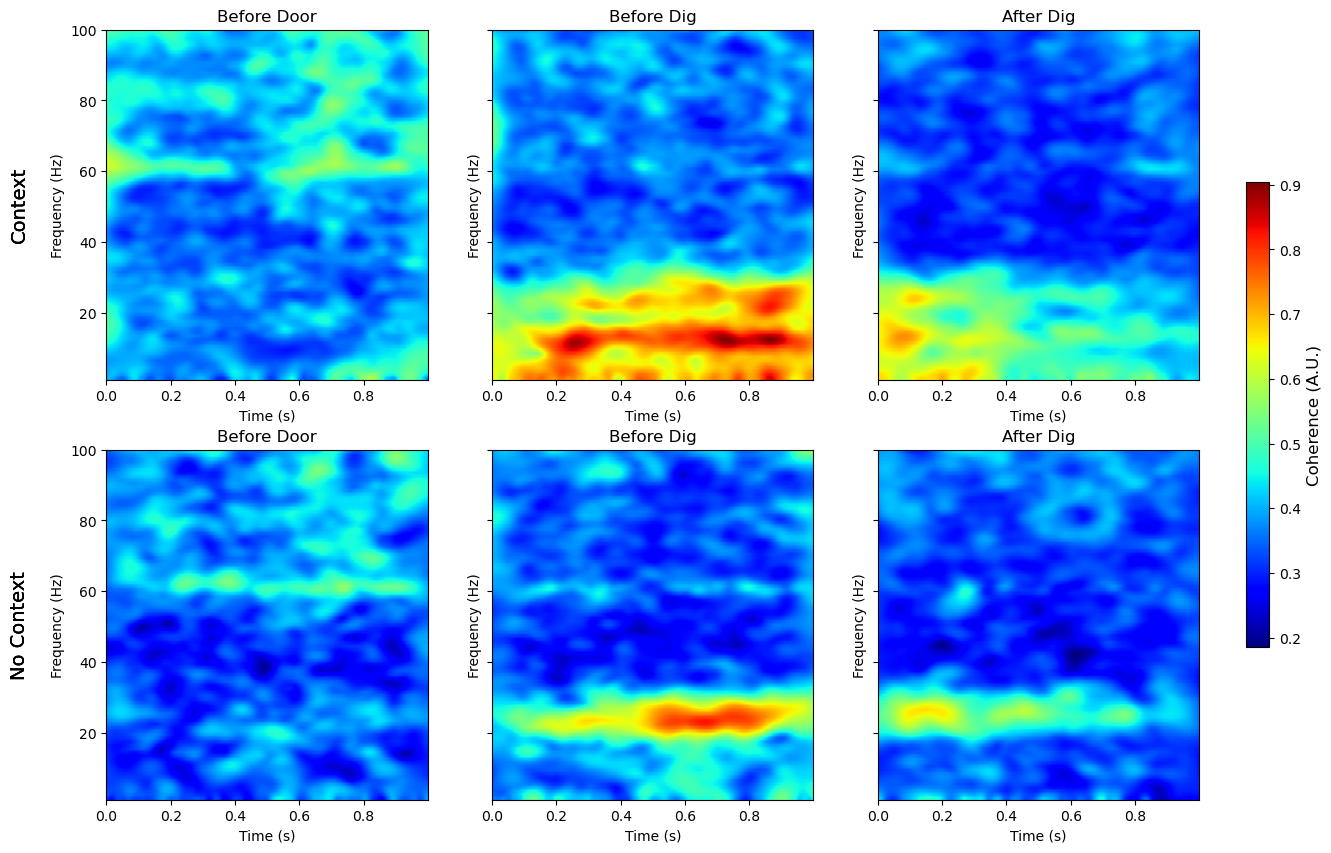

In [98]:

##############

time_window = 1
fs = 2000  # Sampling frequency
tanh_norm = True

###############

if tanh_norm:
    suffix ='_normalized'
else:
    suffix ='_non-normalized'

all_con_data_df=pd.read_pickle(savepath+'marked_coherence_spectrogram_before_after_door_dig_truncated_{}{}_251125.pkl'.format(int(time_window*fs), suffix))
event_list=['mne_epoch_door_before','mne_epoch_dig_before','mne_epoch_dig_after']

%matplotlib inline

times=np.arange(0, time_window, 1/fs)
fig, axs=plt.subplots(2,3, figsize=(15,10), sharey=True)
vmin = all_con_data_df[event_list].applymap(np.min).min().min()
vmax = all_con_data_df[event_list].applymap(np.max).max().max()
event_names=['Before Door','Before Dig','After Dig']
for i, event in enumerate(event_list):
    axs[0,i].imshow(all_con_data_df[event][0], extent=[times[0], times[-1], 1, 100],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    axs[0,i].set_xlabel('Time (s)')
    axs[0,i].set_ylabel('Frequency (Hz)')
    axs[0,i].set_title(event_names[i])

    axs[1,i].imshow(all_con_data_df[event][1], extent=[times[0], times[-1], 1, 100],
                   aspect='auto', origin='lower', cmap='jet', vmin=vmin, vmax=vmax)
    axs[1,i].set_xlabel('Time (s)')
    axs[1,i].set_ylabel('Frequency (Hz)')
    axs[1,i].set_title(event_names[i])
    axs[0,0].text(-0.3, 0.5, 'Context', transform=axs[0,0].transAxes, fontsize=14, verticalalignment='center', rotation=90)
    axs[1,0].text(-0.3, 0.5, 'No Context', transform=axs[1,0].transAxes, fontsize=14, verticalalignment='center', rotation=90)
    # Add a colorbar
cbar = fig.colorbar(axs[0,0].images[0], ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('Coherence (A.U.)', fontsize=12)
fig.savefig(savepath+f'marked_coherence_spectrogram_before_after_door_dig_{int(time_window*fs/2)}ms{suffix}_231125.png', dpi=300, bbox_inches='tight')
plt.show()

## Everything Together from scratch

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

def ind_exp_coherence(epoch):
    """
    Calculate coherence between AON and vHp channels for given epochs.
    
    Parameters:
    -----------
    epoch : mne.EpochsArray
        Epoch data containing AON and vHp channels
    
    Returns:
    --------
    coherence : np.ndarray
        Mean coherence across AON-vHp channel pairs (freqs x time)
    """
    event_epoch = epoch
    print(f"Number of epochs: {event_epoch.events.shape[0]}")
    
    if event_epoch.events.shape[0] < 5:
        print(f"Skipping due to insufficient events (< 5)")
        raise TypeError("Insufficient events for coherence calculation")
    
    fmin = 1
    fmax = 100
    fs = 2000
    freqs = np.arange(fmin, fmax)
    n_cycles = freqs / 3
    
    con = mne_connectivity.spectral_connectivity_epochs(
        event_epoch, method='coh', sfreq=int(fs),
        mode='cwt_morlet', cwt_freqs=freqs,
        cwt_n_cycles=n_cycles, verbose=False, fmin=fmin, fmax=fmax, faverage=False
    )
    
    coh = con.get_data(output='dense')
    indices = con.names
    
    aon_vHp_con = []
    for i in range(coh.shape[0]):
        for j in range(coh.shape[1]):
            if 'AON' in indices[j] and 'vHp' in indices[i]:
                coherence = coh[i, j, :, :]
                coherence = np.arctanh(coherence)
                aon_vHp_con.append(coherence)
    
    return np.mean(aon_vHp_con, axis=0)


def ind_exp_power(epoch, area):
    """
    Calculate power for a specific brain area across epochs.
    
    Parameters:
    -----------
    epoch : mne.EpochsArray
        Epoch data
    area : str
        Brain area identifier (e.g., 'AON' or 'vHp')
    
    Returns:
    --------
    num_of_epochs : int
        Number of epochs
    averaged_channel_power : np.ndarray
        Power for each epoch, averaged across channels (epochs x freqs x time)
    mean_ch_power : np.ndarray
        Power averaged across both epochs and channels (freqs x time)
    """
    fmin = 1
    fmax = 100
    fs = 2000
    freqs = np.arange(fmin, fmax)
    n_cycles = freqs / 3
    
    power = epoch.compute_tfr(
        method="morlet", freqs=freqs, n_cycles=n_cycles, return_itc=False, average=False,
    )
    
    print(f"Channels: {epoch.ch_names}")
    area_channels = [channel for channel in epoch.ch_names if area in channel]
    area_epoch = power.copy()
    area_epoch.pick(area_channels)
    
    averaged_epoch_power = area_epoch.average(dim='epochs')
    averaged_channel_power = np.mean(area_epoch.get_data(), axis=1)
    num_of_epochs = area_epoch.get_data().shape[0]
    
    print(f"Data shape before mean: {averaged_epoch_power.shape}")
    mean_ch_power = np.mean(averaged_epoch_power.get_data(), axis=0)
    print(f"Data shape after mean: {mean_ch_power.shape}")
    
    return num_of_epochs, averaged_channel_power, mean_ch_power


def plot_epochs_grid_with_metadata(epochs, metadata_cols=['time_diff'], n_cols=4, pre_marked_bad=None, position=None, power_figs=None):
    """
    Interactive epoch grid viewer that displays all epochs and metadata.
    Click on epochs to mark as bad.
    
    Parameters:
    -----------
    epochs : mne.EpochsArray
        The epochs object to visualize
    metadata_cols : list
        List of metadata column names to display
    n_cols : int
        Number of columns in the grid
    pre_marked_bad : list, optional
        List of epoch indices that are already marked as bad
    position : tuple, optional
        (x, y) position in pixels for the figure window
    power_figs : tuple, optional
        (fig1, fig2) power/coherence figures to close when this window closes
    
    Usage:
    ------
    bad_epochs = plot_epochs_grid_with_metadata(mne_epoch_door_before, ['time_diff', 'trial_type'], n_cols=5)
    # Click on epochs to toggle bad/good
    # Press 'q' to finish and close
    """
    
    n_epochs = len(epochs)
    n_rows = int(np.ceil(n_epochs / n_cols))
    
    # Initialize with pre-marked bad epochs if provided
    if pre_marked_bad is None:
        bad_epochs = set()
    else:
        bad_epochs = set(pre_marked_bad)
        print(f"Starting with {len(bad_epochs)} pre-marked bad epochs: {sorted(list(bad_epochs))}")
    
    # Create figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    
    # Position the window if specified
    if position is not None:
        mngr = fig.canvas.manager
        try:
            mngr.window.setGeometry(position[0], position[1], 400*n_cols, 300*n_rows)
        except:
            try:
                mngr.window.wm_geometry(f"+{position[0]}+{position[1]}")
            except:
                pass
    
    fig.suptitle('Click on epochs to mark as BAD (red border). Press "q" when done.', 
                 fontsize=14, fontweight='bold')
    
    # Flatten axes for easier indexing
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    axes = axes.flatten() if n_rows > 1 or n_cols > 1 else [axes]
    
    # Store rectangles for each subplot
    rectangles = {}
    
    def plot_epoch(idx, ax):
        """Plot a single epoch in the given axis"""
        ax.clear()
        
        if idx >= n_epochs:
            ax.axis('off')
            return
        
        # Get epoch data
        epoch_data = epochs[idx].get_data()[0]  # shape: (n_channels, n_times)
        times = epochs.times
        
        # Plot each channel with offset
        for ch_idx, ch_data in enumerate(epoch_data):
            ax.plot(times, ch_data + ch_idx * 5, linewidth=0.8, alpha=0.7)
        
        # Create title with metadata
        title = f"Epoch {idx}"
        if epochs.metadata is not None:
            for col in metadata_cols:
                if col in epochs.metadata.columns:
                    val = epochs.metadata.iloc[idx][col]
                    if isinstance(val, (int, float)):
                        title += f"\n{col}: {val:.3f}"
                    else:
                        title += f"\n{col}: {val}"
        
        ax.set_title(title, fontsize=9, fontweight='bold')
        ax.set_xlabel('Time (s)', fontsize=8)
        ax.tick_params(labelsize=7)
        ax.grid(True, alpha=0.3)
        
        # Add red border if marked as bad
        if idx in bad_epochs:
            for spine in ax.spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(4)
            ax.set_facecolor('#ffcccc')
        else:
            for spine in ax.spines.values():
                spine.set_edgecolor('black')
                spine.set_linewidth(1)
            ax.set_facecolor('white')
    
    def update_all_plots():
        """Redraw all epoch plots"""
        for idx, ax in enumerate(axes):
            plot_epoch(idx, ax)
        fig.canvas.draw_idle()
    
    def on_click(event):
        """Handle mouse click events"""
        if event.inaxes is None:
            return
        
        # Find which subplot was clicked
        for idx, ax in enumerate(axes):
            if ax == event.inaxes and idx < n_epochs:
                # Toggle bad epoch status
                if idx in bad_epochs:
                    bad_epochs.remove(idx)
                    print(f"Epoch {idx} unmarked as bad (Total bad: {len(bad_epochs)})")
                else:
                    bad_epochs.add(idx)
                    print(f"Epoch {idx} marked as bad (Total bad: {len(bad_epochs)})")
                
                # Redraw just this subplot
                plot_epoch(idx, ax)
                fig.canvas.draw_idle()
                break
    
    def on_key(event):
        """Handle keyboard events"""
        if event.key == 'q':
            # Close power/coherence figures if provided
            if power_figs is not None:
                try:
                    plt.close(power_figs[0])
                    plt.close(power_figs[1])
                    print("Closed power/coherence plots")
                except:
                    pass
            plt.close(fig)
        elif event.key == 'r':
            # Reset all bad epochs
            bad_epochs.clear()
            print("All bad epoch markings cleared")
            update_all_plots()
    
    # Connect event handlers
    fig.canvas.mpl_connect('button_press_event', on_click)
    fig.canvas.mpl_connect('key_press_event', on_key)
    
    # Initial plot of all epochs
    update_all_plots()
    
    plt.tight_layout()
    plt.show(block=True)
    
    # Return list of bad epochs (after window closes)
    bad_list = sorted(list(bad_epochs))
    print(f"\n=== FINAL RESULTS ===")
    print(f"Total bad epochs marked: {len(bad_list)}")
    print(f"Bad epoch indices: {bad_list}")
    
    return bad_list


def plot_coherence_and_power(epochs, rat='', task='', date='', event_name='', time_window=1.0, 
                            ind_exp_coherence=None, ind_exp_power=None, block=False, position=None):
    """
    Plot coherence and power for all epochs to help identify bad epochs.
    
    Parameters:
    -----------
    epochs : mne.EpochsArray
        The epochs object to analyze
    rat : str
        Rat ID for plot title
    task : str
        Task name for plot title
    date : str
        Date for plot title
    event_name : str
        Event name for plot title
    time_window : float
        Time window for extent in plots
    ind_exp_coherence : function
        Function to calculate coherence (must be provided)
    ind_exp_power : function
        Function to calculate power (must be provided)
    block : bool
        If True, blocks execution until plots are closed
    position : tuple, optional
        (x, y) position in pixels for the figure window
    
    Returns:
    --------
    fig, fig2 : matplotlib figures
        The two figure objects (for non-blocking mode)
    
    Usage:
    ------
    plot_coherence_and_power(
        test_epoch, 
        rat='dk6', 
        task='context', 
        date='20230616',
        event_name='dig_before',
        time_window=1.0,
        ind_exp_coherence=ind_exp_coherence,
        ind_exp_power=ind_exp_power,
        block=False,  # Don't block, keep plots open
        position=(100, 100)  # Position on screen
    )
    """
    
    if ind_exp_coherence is None or ind_exp_power is None:
        raise ValueError("Must provide ind_exp_coherence and ind_exp_power functions")
    
    # Calculate coherence and power
    coherence = ind_exp_coherence(epochs)
    num_of_epochs, aon_power, avg_aon_power = ind_exp_power(epochs, "AON")
    num_of_epochs, vhp_power, avg_vhp_power = ind_exp_power(epochs, "vHp")
    
    # Figure 1: Average coherence and power
    fig = plt.figure(figsize=(15, 5))
    if position is not None:
        mngr = fig.canvas.manager
        # Try to position the window (method depends on backend)
        try:
            mngr.window.setGeometry(position[0], position[1], 1500, 500)
        except:
            try:
                mngr.window.wm_geometry(f"+{position[0]}+{position[1]}")
            except:
                pass  # If positioning fails, just use default
    
    fig.suptitle(f'{rat} {task} {date} {event_name}', fontsize=14, fontweight='bold')
    
    ax0 = fig.add_subplot(1, 3, 1)
    im0 = ax0.imshow(coherence, extent=[0, time_window, 1, 100], aspect='auto', origin='lower', cmap='jet')
    ax0.set_title("Coherence")
    ax0.set_xlabel("Time (s)")
    ax0.set_ylabel("Frequency (Hz)")
    plt.colorbar(im0, ax=ax0)
    
    ax1 = fig.add_subplot(1, 3, 2)
    im1 = ax1.imshow(avg_aon_power, extent=[0, time_window, 1, 100], aspect='auto', origin='lower', cmap='jet')
    ax1.set_title("AON Power")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Frequency (Hz)")
    plt.colorbar(im1, ax=ax1)
    
    ax2 = fig.add_subplot(1, 3, 3)
    im2 = ax2.imshow(avg_vhp_power, extent=[0, time_window, 1, 100], aspect='auto', origin='lower', cmap='jet')
    ax2.set_title("vHp Power")
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Frequency (Hz)")
    plt.colorbar(im2, ax=ax2)
    
    plt.tight_layout()
    
    # Figure 2: Individual epoch power
    fig2 = plt.figure(figsize=(20, 5))
    if position is not None:
        mngr2 = fig2.canvas.manager
        # Position below first figure (offset by height)
        try:
            mngr2.window.setGeometry(position[0], position[1] + 550, 2000, 500)
        except:
            try:
                mngr2.window.wm_geometry(f"+{position[0]}+{position[1] + 550}")
            except:
                pass
    
    fig2.suptitle(f'{rat} {task} {date} {event_name} - Individual Epochs', fontsize=14, fontweight='bold')
    
    for rowi, power in enumerate([aon_power, vhp_power]):
        for coli in range(power.shape[0]):
            ax = fig2.add_subplot(2, num_of_epochs, rowi * num_of_epochs + coli + 1)
            im = ax.imshow(power[coli, :, :], extent=[0, time_window, 1, 100], aspect='auto', origin='lower', cmap='jet')
            ax.set_title(f'Epoch {coli}', fontsize=9)
            
            if coli == 0:
                if rowi == 0:
                    ax.text(-0.3, 0.5, "AON Power", transform=ax.transAxes, fontsize=10, 
                           verticalalignment='center', rotation=90)
                else:
                    ax.text(-0.3, 0.5, "vHp Power", transform=ax.transAxes, fontsize=10, 
                           verticalalignment='center', rotation=90)
            
            ax.set_xticks([])
            ax.set_yticks([])
    
    plt.tight_layout()
    
    if block:
        plt.show(block=True)
    else:
        plt.show(block=False)
        plt.pause(0.1)  # Brief pause to render plots
    
    return fig, fig2


def annotate_and_clean_epochs_dataframe(df, event_columns=None, metadata_cols=['time_diff', 'trial_type', 'dig_type'], 
                                       n_cols=5, savepath=None, show_power_coherence=False, 
                                       time_window=1.0, ind_exp_coherence=None, ind_exp_power=None):
    """
    Annotate bad epochs for all event types in a dataframe and create cleaned versions.
    Optionally display coherence and power plots before annotation.
    
    Parameters:
    -----------
    df : pd.DataFrame
        Dataframe containing epoch data columns
    event_columns : list, optional
        List of column names containing epoch data to annotate.
        If None, uses default event columns.
    metadata_cols : list
        Metadata columns to display during annotation
    n_cols : int
        Number of columns in the grid display
    savepath : str, optional
        Path to save the annotated dataframe. If None, doesn't save.
    show_power_coherence : bool
        If True, show coherence and power plots before epoch annotation
    time_window : float
        Time window for power/coherence plots
    ind_exp_coherence : function
        Function to calculate coherence (required if show_power_coherence=True)
    ind_exp_power : function
        Function to calculate power (required if show_power_coherence=True)
    
    Returns:
    --------
    df_annotated : pd.DataFrame
        Dataframe with added columns:
        - bad_epochs_{event}: list of bad epoch indices
        - dropped_epochs_{event}: clean epoch data with bad epochs removed
    
    Usage:
    ------
    # Without power/coherence plots:
    con_data_df_annotated = annotate_and_clean_epochs_dataframe(
        con_data_df,
        event_columns=['mne_epoch_door_before', 'mne_epoch_dig_before'],
        metadata_cols=['time_diff', 'trial_type', 'dig_type'],
        n_cols=5,
        savepath=savepath
    )
    
    # With power/coherence plots:
    con_data_df_annotated = annotate_and_clean_epochs_dataframe(
        con_data_df,
        event_columns=['mne_epoch_door_before'],
        show_power_coherence=True,
        time_window=1.0,
        ind_exp_coherence=ind_exp_coherence,
        ind_exp_power=ind_exp_power,
        savepath='path/to/save/'
    )
    """
    
    # Default event columns if not specified
    if event_columns is None:
        event_columns = ['mne_epoch_door_before', 'mne_epoch_door_after', 
                        'mne_epoch_dig_before', 'mne_epoch_dig_after',
                        'mne_epoch_around_door', 'mne_epoch_around_dig']
    
    # Check if power/coherence functions are provided when needed
    if show_power_coherence and (ind_exp_coherence is None or ind_exp_power is None):
        raise ValueError("Must provide ind_exp_coherence and ind_exp_power functions when show_power_coherence=True")
    
    # Make a copy to avoid modifying original
    df_annotated = df.copy()
    
    # Step 1: For each event type, collect bad epochs for all rows
    for event_col in event_columns:
        print(f"\n{'#'*70}")
        print(f"# Processing event type: {event_col}")
        print(f"{'#'*70}\n")
        
        # Collect bad epochs for this event type across all rows
        all_bad_epochs_for_event = []
        
        for row in range(df_annotated.shape[0]):
            print(f"\n{'='*60}")
            print(f"Row {row}/{df_annotated.shape[0]-1}")
            
            rat = df_annotated.iloc[row]['rat_id']
            task = df_annotated.iloc[row]['task']
            date = df_annotated.iloc[row]['date']
            
            print(f"Rat: {rat}, Task: {task}, Date: {date}")
            print(f"{'='*60}")
            
            # Get the event data
            event_data = df_annotated.iloc[row][event_col]
            
            # Optionally show power and coherence plots first
            if show_power_coherence:
                print("\nDisplaying coherence and power plots...")
                fig1, fig2 = plot_coherence_and_power(
                    event_data,
                    rat=rat,
                    task=task,
                    date=date,
                    event_name=event_col.replace('mne_epoch_', ''),
                    time_window=time_window,
                    ind_exp_coherence=ind_exp_coherence,
                    ind_exp_power=ind_exp_power,
                    block=False  # Don't block - keep plots open
                )
            
            # Annotate bad epochs with iterative refinement
            print("\nNow annotate bad epochs in the grid viewer...")
            if show_power_coherence:
                print("(Power/coherence plots will stay open for reference)")
            
            # Iterative annotation loop
            iteration = 1
            all_marked_bad = []
            
            while True:
                print(f"\n--- Annotation Iteration {iteration} ---")
                if iteration > 1:
                    print(f"Previously marked bad epochs: {all_marked_bad}")
                    # Show original power/coherence plots again for reference
                    print("Displaying ORIGINAL coherence and power plots for reference...")
                    fig1, fig2 = plot_coherence_and_power(
                        event_data,
                        rat=rat,
                        task=task,
                        date=f"{date} (ORIGINAL - Iteration {iteration})",
                        event_name=event_col.replace('mne_epoch_', ''),
                        time_window=time_window,
                        ind_exp_coherence=ind_exp_coherence,
                        ind_exp_power=ind_exp_power,
                        block=False,  # Don't block
                        position=(0, 0)  # Position on left monitor
                    )
                else:
                    # First iteration - position on left monitor
                    if show_power_coherence:
                        fig1, fig2 = plot_coherence_and_power(
                            event_data,
                            rat=rat,
                            task=task,
                            date=date,
                            event_name=event_col.replace('mne_epoch_', ''),
                            time_window=time_window,
                            ind_exp_coherence=ind_exp_coherence,
                            ind_exp_power=ind_exp_power,
                            block=False,
                            position=(0, 0)  # Left monitor
                        )
                
                # Show grid viewer on right monitor, passing power figures to close with it
                bad_epochs = plot_epochs_grid_with_metadata(
                    event_data, 
                    metadata_cols=metadata_cols,
                    n_cols=n_cols,
                    pre_marked_bad=all_marked_bad,  # Pass previously marked epochs
                    position=(1920, 0) if show_power_coherence else None,  # Right monitor (adjust 1920 to your left monitor width)
                    power_figs=(fig1, fig2) if show_power_coherence else None  # Pass figures to close
                )
                
                # Update the list of all bad epochs
                all_marked_bad = bad_epochs
                
                # Note: Power/coherence plots are now automatically closed when grid viewer closes
                
                # Show cleaned data if epochs were dropped
                if show_power_coherence and len(all_marked_bad) > 0:
                    print(f"\n{len(all_marked_bad)} bad epochs marked: {all_marked_bad}")
                    print(f"Original number of epochs: {len(event_data)}")
                    
                    # Create clean version
                    event_data_copy = event_data.copy()
                    print(f"After copy: {len(event_data_copy)} epochs")
                    
                    event_data_copy.drop(all_marked_bad, reason='manual_review')
                    print(f"After marking bad: {len(event_data_copy)} total, selection: {event_data_copy.selection}")
                    print(f"Drop log: {event_data_copy.drop_log}")
                    
                    event_data_clean = event_data_copy.drop_bad()
                    print(f"After drop_bad: {type(event_data_clean)}, value: {event_data_clean}")
                    
                    # Check if drop_bad returned None or the object itself
                    if event_data_clean is None:
                        # drop_bad modifies in place and returns None
                        event_data_clean = event_data_copy
                        print(f"drop_bad returned None, using event_data_copy: {len(event_data_clean)} epochs")
                    
                    # Check if any epochs remain
                    if len(event_data_clean) == 0:
                        print("WARNING: All epochs were marked as bad! No data remains.")
                        response = input("Do you want to go back and mark fewer epochs? (y/n): ").strip().lower()
                        if response == 'y':
                            iteration += 1
                            continue
                        else:
                            print("Keeping all epochs marked as bad (empty dataset).")
                            break
                    
                    print(f"Clean data has {len(event_data_clean)} epochs")
                    
                    # Check if enough epochs remain for coherence calculation
                    if len(event_data_clean) < 5:
                        print(f"WARNING: Only {len(event_data_clean)} epochs remain (need at least 5 for coherence).")
                        response = input("Do you want to go back and mark fewer epochs? (y/n): ").strip().lower()
                        if response == 'y':
                            iteration += 1
                            continue
                        else:
                            print("Proceeding with limited epochs (coherence calculation may fail).")
                    
                    # Show power/coherence for cleaned data
                    print("Displaying CLEANED coherence and power plots...")
                    print("Close the plots to continue, or answer 'y' to refine (mark more bad epochs)")
                    
                    try:
                        fig1_clean, fig2_clean = plot_coherence_and_power(
                            event_data_clean,
                            rat=rat,
                            task=task,
                            date=f"{date} (CLEANED - Iteration {iteration})",
                            event_name=event_col.replace('mne_epoch_', ''),
                            time_window=time_window,
                            ind_exp_coherence=ind_exp_coherence,
                            ind_exp_power=ind_exp_power,
                            block=True  # Block to review cleaned data
                        )
                    except (TypeError, AttributeError, ValueError) as e:
                        print(f"WARNING: Could not generate cleaned plots. Error: {e}")
                        print(f"Error type: {type(e)}")
                        import traceback
                        traceback.print_exc()
                        print("This may happen if too few epochs remain or data is invalid.")
                        response = input("Do you want to go back and mark fewer epochs? (y/n): ").strip().lower()
                        if response == 'y':
                            iteration += 1
                            continue
                        else:
                            print("Proceeding with current epoch selection.")
                            break
                    
                    # Ask if user wants to refine further
                    response = input("\nDo you want to mark MORE bad epochs? (y/n): ").strip().lower()
                    if response == 'y':
                        iteration += 1
                        continue  # Go back to annotation
                    else:
                        print("Finalizing annotations...")
                        break
                else:
                    # No bad epochs marked or show_power_coherence is False
                    if show_power_coherence and len(all_marked_bad) == 0:
                        print("\nNo bad epochs marked - data is already clean!")
                    break
            
            # Store the final list of bad epochs
            all_bad_epochs_for_event.append(all_marked_bad)
        
        # Step 2: Add column "bad_epochs_{event}"
        bad_col_name = f'bad_epochs_{event_col.replace("mne_epoch_", "")}'
        df_annotated[bad_col_name] = all_bad_epochs_for_event
        
        # Step 3: Create "dropped_epochs_{event}" column
        # This is a copy of the event with bad epochs dropped
        dropped_epochs_list = []
        
        for row in range(df_annotated.shape[0]):
            # Get original event data
            event_data = df_annotated.iloc[row][event_col]
            
            # Make a copy to avoid modifying the original
            event_data_copy = event_data.copy()
            
            # Get bad epochs for this row
            bad_epochs = all_bad_epochs_for_event[row]
            
            # Drop bad epochs if any exist
            if len(bad_epochs) > 0:
                event_data_copy.drop(bad_epochs, reason='manual_review')
                # Create clean version with bad epochs actually removed
                event_data_clean = event_data_copy.drop_bad()
            else:
                event_data_clean = event_data_copy
            
            dropped_epochs_list.append(event_data_clean)
        
        # Add the dropped_epochs column
        dropped_col_name = f'dropped_epochs_{event_col.replace("mne_epoch_", "")}'
        df_annotated[dropped_col_name] = dropped_epochs_list
        
        print(f"\n✓ Completed {event_col}")
        print(f"  - Added column: {bad_col_name}")
        print(f"  - Added column: {dropped_col_name}")
    
    # Step 4: Save the final dataframe if savepath provided
    if savepath is not None:
        save_file = savepath + 'con_data_df_manual_annotated.pkl'
        df_annotated.to_pickle(save_file)
        print(f"\n✓ Saved annotated dataframe to: {save_file}")
    
    # Step 5: Print summary
    print("\n" + "="*70)
    print("FINAL SUMMARY")
    print("="*70)
    for row in range(df_annotated.shape[0]):
        print(f"\nRow {row} - {df_annotated.iloc[row]['rat_id']} - {df_annotated.iloc[row]['task']}")
        for event_col in event_columns:
            bad_col_name = f'bad_epochs_{event_col.replace("mne_epoch_", "")}'
            dropped_col_name = f'dropped_epochs_{event_col.replace("mne_epoch_", "")}'
            
            n_total = len(df_annotated.iloc[row][event_col])
            n_bad = len(df_annotated.iloc[row][bad_col_name])
            n_clean = len(df_annotated.iloc[row][dropped_col_name])
            
            print(f"  {event_col}: {n_total} total → {n_bad} bad → {n_clean} clean")
    
    return df_annotated


# Usage example:
# import matplotlib.pyplot as plt
# %matplotlib qt  # Or %matplotlib tk - allows multiple windows
#
# con_data_df_annotated = annotate_and_clean_epochs_dataframe(
#     con_data_df,
#     event_columns=['mne_epoch_door_before', 'mne_epoch_dig_before'],
#     metadata_cols=['time_diff', 'trial_type', 'dig_type'],
#     n_cols=5,
#     show_power_coherence=True,
#     time_window=1.0,
#     ind_exp_coherence=ind_exp_coherence,
#     ind_exp_power=ind_exp_power,
#     savepath=savepath
# )

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib qt

# Load your data
con_data_df = pd.read_pickle(savepath + f'raw_mne_epochs_array_df_truncated_{int(time_window*fs)}.pkl')
con_data_df_small = con_data_df.iloc[0:1,:]
print(con_data_df_small)


In [ ]:
# Run the complete annotation workflow
con_data_df_annotated = annotate_and_clean_epochs_dataframe(
    df=con_data_df_small,
    event_columns=['mne_epoch_door_before', 'mne_epoch_dig_before', 'mne_epoch_dig_after'],
    metadata_cols=['time_diff', 'trial_type', 'dig_type'],
    n_cols=5,
    show_power_coherence=True,
    time_window=1.0,
    ind_exp_coherence=ind_exp_coherence,  # Your function
    ind_exp_power=ind_exp_power,          # Your function
    savepath=savepath
)

# The result will have new columns:
# - bad_epochs_door_before: list of bad epoch indices
# - dropped_epochs_door_before: clean epochs with bad ones removed
# - bad_epochs_dig_before: list of bad epoch indices  
# - dropped_epochs_dig_before: clean epochs with bad ones removed

In [ ]:
import tkinter as tk
root = tk.Tk()
print(f"Screen width: {root.winfo_screenwidth()}")
root.destroy()

## End of Code

In [ ]:

#fig = test_epoch.compute_psd(fmin=1, fmax=100, method='multitaper').plot(average=True, amplitude=False, picks="data")
test_epoch.plot_image(combine="mean", picks=aon_indices)
test_epoch.plot_image(combine="mean", picks=vHp_indices)

In [ ]:
mne_all_channels_data = mne.io.RawArray(all_channels_data, info)
mne_all_channels_data.plot(scalings='auto', show=True)

In [ ]:
all_data_epochs.plot(n_epochs=10, events=True)

In [ ]:
all_data_epochs["1"].plot_image(combine="mean", colorbar=True, show=True)

In [ ]:
all_data_epochs["1"].plot_tfr(fmin=4, fmax=100, method='multitaper', show=True, picks=data_channels, spatial_colors=True)

## Plotting TFR of raw data (complete experiment) to check for noise in each trial

In [ ]:
tfr= mne_all_channels_data.compute_tfr(method='morlet', freqs=np.arange(1, 100), n_cycles=np.arange(1, 100)/3,picks=data_channels, decim=1, n_jobs=1, verbose=True)
print(tfr.info)

In [ ]:
tfr.plot([0])

In [ ]:
# Plot the TFR for each channel
n_channels = all_ch_data_tfr.shape[1]
n_freqs = all_ch_data_tfr.shape[2]
n_times = all_ch_data_tfr.shape[3]

fig, axes = plt.subplots(n_channels, 1, figsize=(12, 3 * n_channels), sharex=True)
if n_channels == 1:
    axes = [axes]

for ch in range(n_channels):
    ax = axes[ch]
    im = ax.imshow(
        all_ch_data_tfr[0, ch], 
        aspect='auto', 
        origin='lower',
        extent=[times[0], times[-1], freqs[0], freqs[-1]],
        cmap='viridis'
    )
    ax.set_title(f"TFR - {all_channels[ch]}")
    ax.set_ylabel("Frequency (Hz)")
    fig.colorbar(im, ax=ax, orientation='vertical', label='Power')

axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

